In this notebook, we'll build a deep learning model to classify a person's walking condition based on joint angle data. The goal is to predict whether a person is walking normally (unbraced), with a knee brace, or with an ankle brace.

This is a multivariate time-series classification problem. We will use a Long Short-Term Memory (LSTM) network, which is excellent for learning patterns from sequential data like this.

Step 1: Setup and Library Imports
First, let's set up our environment by importing the necessary libraries. We'll need ucimlrepo to fetch the data, pandas and numpy for data manipulation, matplotlib and seaborn for plotting, and tensorflow.keras for building our deep learning model.

In [ ]:
# For data fetching and manipulation
!pip install ucimlrepo
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

Step 2: Load the Dataset
Next, we'll fetch the "Multivariate Gait Data" from the UCI Machine Learning Repository using the provided utility. This gives us the features (X) and the target (y), which in this dataset is the joint angle value. We'll combine them into a single DataFrame for easier processing.

In [2]:
# Fetch dataset from UCI repository
multivariate_gait_data = fetch_ucirepo(id=760)

# Features (X) and target (y)
X_features = multivariate_gait_data.data.features
y_target = multivariate_gait_data.data.targets

# Combine features and target into a single dataframe
df = pd.concat([X_features, y_target], axis=1)

print("Dataset successfully loaded.")
df.head()

Dataset successfully loaded.


,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399


Step 3: Exploratory Data Analysis (EDA)
Before building a model, it's crucial to understand our data. We will check its structure, look for missing values, and visualize the relationships between different variables.

First, let's get a summary of the dataset.



In [3]:
# Display basic information about the dataset
print("Dataset Info:")
df.info()

print("\n\nDescriptive Statistics:")
df.describe()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181800 entries, 0 to 181799
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   subject      181800 non-null  int64  
 1   condition    181800 non-null  int64  
 2   replication  181800 non-null  int64  
 3   leg          181800 non-null  int64  
 4   joint        181800 non-null  int64  
 5   time         181800 non-null  int64  
 6   angle        181800 non-null  float64
dtypes: float64(1), int64(6)
memory usage: 9.7 MB


Descriptive Statistics:


,subject,condition,replication,leg,joint,time,angle
count,181800.000000,181800.000000,181800.000000,181800.000000,181800.000000,181800.00000,181800.000000
mean,5.500000,2.000000,5.500000,1.500000,2.000000,50.00000,12.149321
std,2.872289,0.816499,2.872289,0.500001,0.816499,29.15484,16.025823
min,1.000000,1.000000,1.000000,1.000000,1.000000,0.00000,-27.004634
25%,3.000000,1.000000,3.000000,1.000000,1.000000,25.00000,1.794457
50%,5.500000,2.000000,5.500000,1.500000,2.000000,50.00000,9.466976
75%,8.000000,3.000000,8.000000,2.000000,3.000000,75.00000,18.559890
max,10.000000,3.000000,10.000000,2.000000,3.000000,100.00000,78.309342


The data is clean with no missing values. The features are all integers, and the target angle is a float.

Now, let's visualize the distribution of our categorical features.

/tmp/ipython-input-3168197249.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], x='condition', data=df, palette='viridis')
/tmp/ipython-input-3168197249.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Unbraced', 'Knee Brace', 'Ankle Brace'])
/tmp/ipython-input-3168197249.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], x='leg', data=df, palette='viridis')
/tmp/ipython-input-3168197249.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['

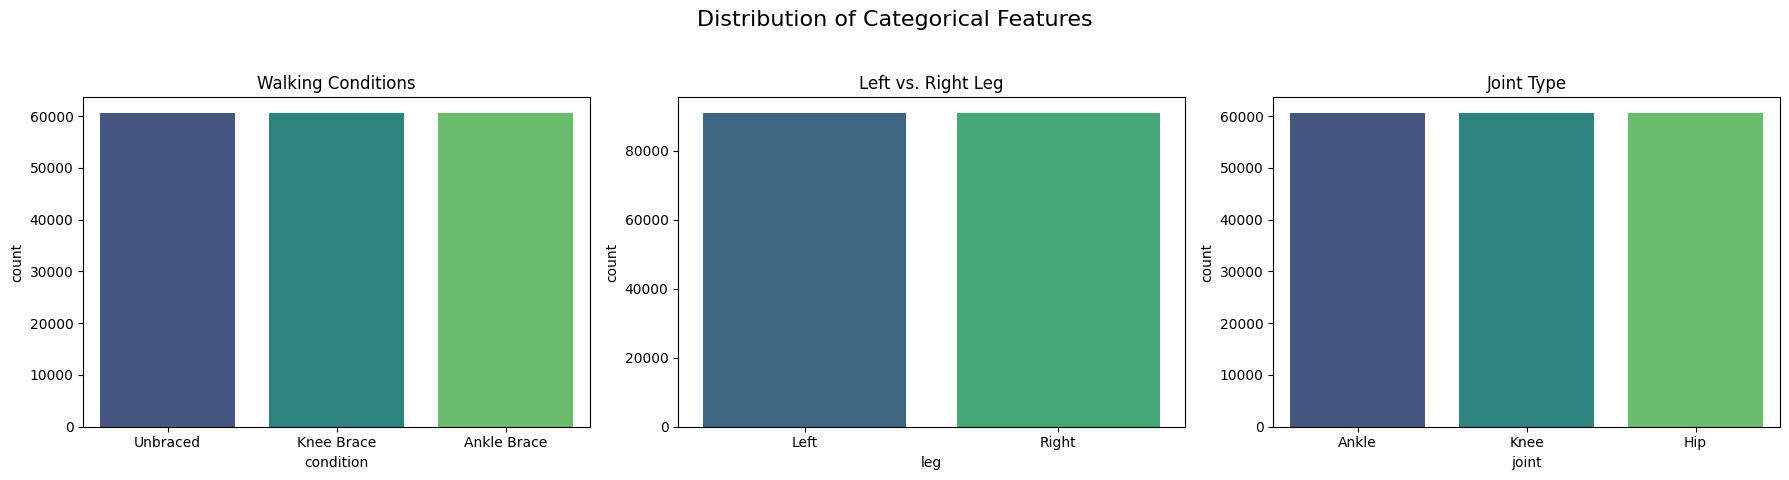

In [4]:
# Plotting distributions of categorical features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Categorical Features', fontsize=16)

sns.countplot(ax=axes[0], x='condition', data=df, palette='viridis')
axes[0].set_title('Walking Conditions')
axes[0].set_xticklabels(['Unbraced', 'Knee Brace', 'Ankle Brace'])

sns.countplot(ax=axes[1], x='leg', data=df, palette='viridis')
axes[1].set_title('Left vs. Right Leg')
axes[1].set_xticklabels(['Left', 'Right'])


sns.countplot(ax=axes[2], x='joint', data=df, palette='viridis')
axes[2].set_title('Joint Type')
axes[2].set_xticklabels(['Ankle', 'Knee', 'Hip'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

The dataset is perfectly balanced across all conditions, legs, and joints, which is ideal.

Visualizing Gait Cycles
The most important part of our EDA is to see if the joint angles differ across the walking conditions. We'll plot the average angle of each joint throughout a full gait cycle (0% to 100%) for each condition. This should reveal the patterns our model will try to learn.

/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.12/dist-packages/

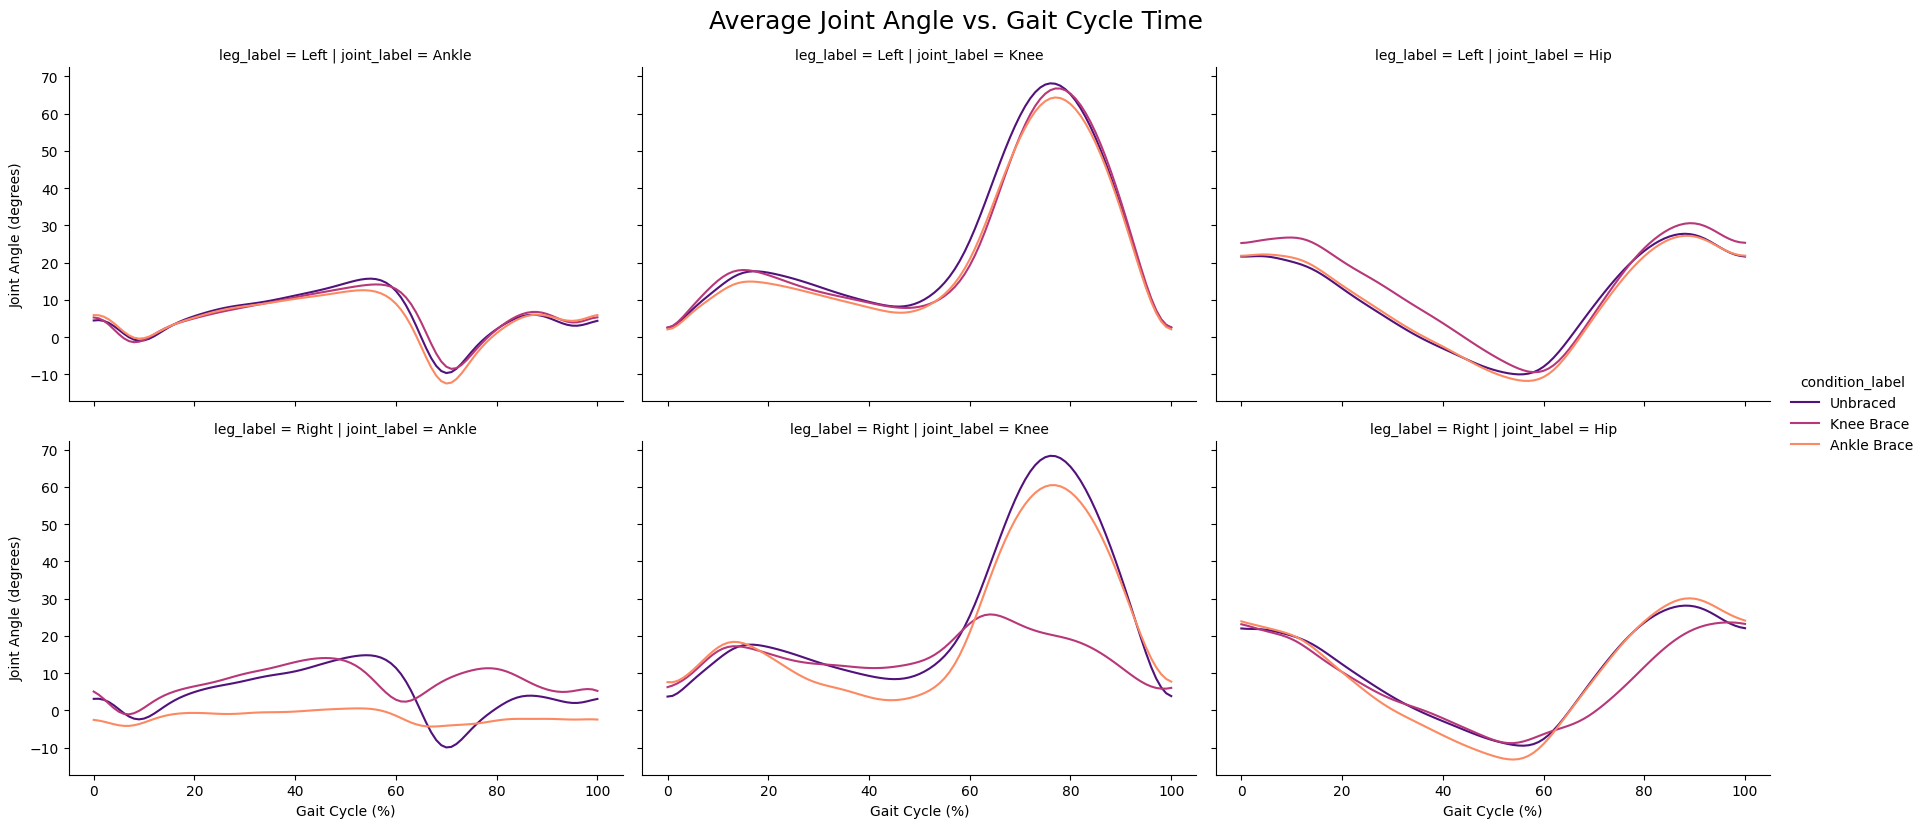

In [5]:
# Map integer codes to readable labels for plotting
condition_map = {1: 'Unbraced', 2: 'Knee Brace', 3: 'Ankle Brace'}
joint_map = {1: 'Ankle', 2: 'Knee', 3: 'Hip'}
leg_map = {1: 'Left', 2: 'Right'}

df['condition_label'] = df['condition'].map(condition_map)
df['joint_label'] = df['joint'].map(joint_map)
df['leg_label'] = df['leg'].map(leg_map)


# Create plots to visualize the average gait cycle for each condition
g = sns.relplot(
    data=df,
    x='time',
    y='angle',
    hue='condition_label',
    col='joint_label',
    row='leg_label',
    kind='line',
    ci=None, # Disables confidence intervals for clarity
    height=4,
    aspect=1.5,
    palette='magma'
)

g.fig.suptitle('Average Joint Angle vs. Gait Cycle Time', fontsize=18, y=1.03)
g.set_axis_labels("Gait Cycle (%)", "Joint Angle (degrees)")
plt.show()

Insight: The plots clearly show distinct patterns for each walking condition, especially for the right leg where the braces were applied. For example, the "Knee Brace" condition significantly changes the right knee's angle profile. These visible differences suggest that a machine learning model should be able to classify the conditions effectively.

Step 4: Data Preprocessing & Sequencing
Our current data format is "long," with one row per time point. LSTMs expect data in a "sequence" format of (samples, timesteps, features).

Sample: A single, complete gait cycle for one leg. (10 subjects * 3 conditions * 10 reps * 2 legs = 600 total samples).

Timesteps: The number of measurements in a sequence, which is 101 (from 0% to 100% of the gait cycle).

Features: The variables measured at each timestep. In our case, these are the angles for the 3 joints (ankle, knee, hip).

We will write a function to reshape the data into this (600, 101, 3) structure.

In [6]:
def create_sequences(data):
    """
    Reshapes the long-format dataframe into sequences for the LSTM model.
    Returns reshaped features (X) and corresponding labels (y).
    """
    # Unique identifiers for each gait cycle instance
    gait_cycles = data.groupby(['subject', 'condition', 'replication', 'leg'])

    num_sequences = len(gait_cycles)
    num_timesteps = 101  # 0-100% of gait cycle
    num_features = 3     # Ankle, Knee, Hip joints

    # Initialize numpy arrays
    X = np.zeros((num_sequences, num_timesteps, num_features))
    y = np.zeros((num_sequences,))

    for i, (group_name, group_df) in enumerate(gait_cycles):
        # The label is the condition for this group
        y[i] = group_name[1] # group_name is (subject, condition, replication, leg)

        # Pivot the table to align joints as features
        pivoted_df = group_df.pivot(index='time', columns='joint', values='angle')

        # Ensure the order of joints (features) is consistent: 1=Ankle, 2=Knee, 3=Hip
        pivoted_df = pivoted_df.reindex(columns=[1, 2, 3])

        # Store the sequence
        X[i, :, :] = pivoted_df.values

    # The labels are 1, 2, 3. Let's make them 0, 1, 2 for categorical encoding.
    y = y - 1

    return X, y

# Create the sequences
X_sequences, y_labels = create_sequences(df)

print("Shape of sequence data (X):", X_sequences.shape)
print("Shape of labels (y):", y_labels.shape)

Shape of sequence data (X): (600, 101, 3)
Shape of labels (y): (600,)


Step 5: Split Data, Scale Features, and Encode Labels
Now we'll prepare the data for training.

Split: Divide the data into training (80%) and testing (20%) sets.

Scale Features: Neural networks perform better with scaled data. We'll use StandardScaler. Important: We fit the scaler only on the training data to avoid data leakage from the test set.

Encode Labels: We'll one-hot encode our target labels (0, 1, 2) into a binary format (e.g., 2 becomes [0, 0, 1]) suitable for a categorical classification model.

In [7]:
# 1. Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_sequences, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

# 2. Scale the features
# The scaler needs 2D data, so we reshape, fit, and then transform back to 3D.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)


# 3. One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))


print("X_train shape:", X_train_scaled.shape)
print("X_test shape:", X_test_scaled.shape)
print("y_train_one_hot shape:", y_train_one_hot.shape)
print("y_test_one_hot shape:", y_test_one_hot.shape)

X_train shape: (480, 101, 3)
X_test shape: (120, 101, 3)
y_train_one_hot shape: (480, 3)
y_test_one_hot shape: (120, 3)


Step 6: Build the LSTM Model
We will build a simple but effective LSTM model using the Keras Sequential API.

Input: Defines the shape of our input data (101 timesteps, 3 features).

LSTM: The core layer for learning from sequences. We use 64 units.

Dropout: A regularization technique to prevent overfitting by randomly dropping units during training.

Dense: A standard fully connected neural network layer.

Output Layer: A Dense layer with 3 units (one for each class) and a softmax activation function to output class probabilities.

In [8]:
# Define model parameters
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2]) # (101, 3)
num_classes = y_train_one_hot.shape[1] # 3

# Build the model
model = Sequential([
    Input(shape=input_shape),
    LSTM(64, return_sequences=False), # Only the last output is needed
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax') # Softmax for multi-class classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,587 (76.51 KB)

 Trainable params: 19,587 (76.51 KB)

 Non-trainable params: 0 (0.00 B)

Step 7: Train the Model
It's time to train our model! We'll use the .fit() method, passing our scaled training data. We'll also use the test set as validation data to monitor performance on unseen data during training.

In [9]:
# Train the model
history = model.fit(
    X_train_scaled,
    y_train_one_hot,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_scaled, y_test_one_hot),
    verbose=1
)

Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.3880 - loss: 1.0868 - val_accuracy: 0.5500 - val_loss: 1.0055
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5027 - loss: 1.0220 - val_accuracy: 0.6333 - val_loss: 0.9072
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5334 - loss: 0.9433 - val_accuracy: 0.6167 - val_loss: 0.7698
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5528 - loss: 0.8582 - val_accuracy: 0.6583 - val_loss: 0.7245
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6743 - loss: 0.7573 - val_accuracy: 0.6917 - val_loss: 0.6904
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6285 - loss: 0.7561 - val_accuracy: 0.7417 - val_loss: 0.6285
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7052 - loss: 0.6948 - val_accuracy: 0.7083 - val_loss: 0.6234
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7285 - loss: 0.6764 - val_accuracy: 0.7667 - v

Step 8: Evaluate Model Performance
After training, we must evaluate how well our model performs on the test set. We will:

Plot the training and validation accuracy/loss to check for overfitting.

Calculate final test accuracy and loss.

Generate a classification report and a confusion matrix for a detailed performance breakdown.

Learning Curves
Let's visualize the model's learning progress.

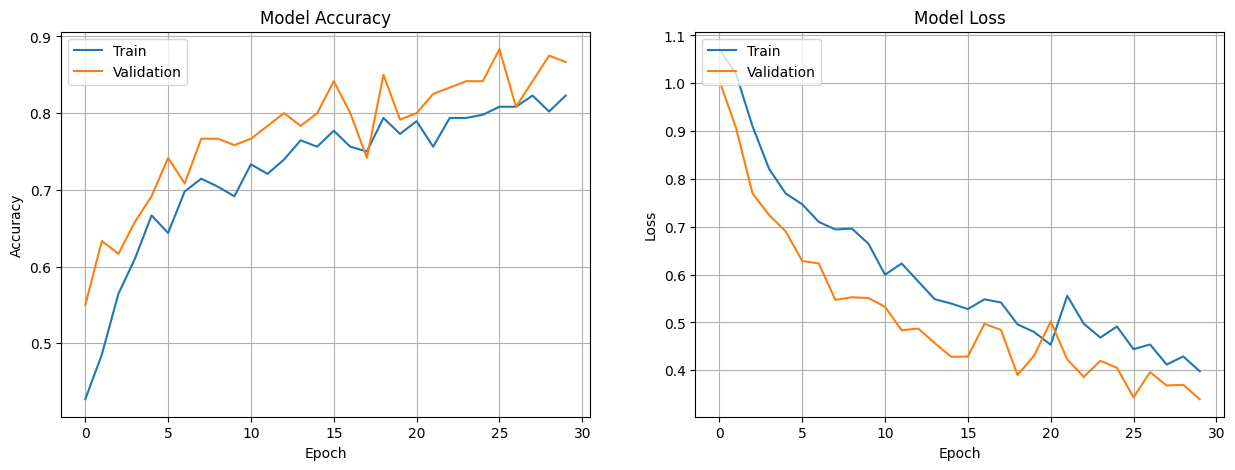

In [10]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax1.grid(True)

    # Plot training & validation loss values
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    ax2.grid(True)

    plt.show()

plot_history(history)

The curves show that the model learned well, with both training and validation accuracy increasing and loss decreasing. The validation accuracy is high and stable, indicating that the model is not significantly overfitting.

Metrics and Confusion Matrix
Now for the final quantitative evaluation on the test set.



Test Accuracy: 86.67%
Test Loss: 0.3396
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

Classification Report:
              precision    recall  f1-score   support

    Unbraced       0.88      0.75      0.81        40
  Knee Brace       0.90      0.95      0.93        40
 Ankle Brace       0.82      0.90      0.86        40

    accuracy                           0.87       120
   macro avg       0.87      0.87      0.86       120
weighted avg       0.87      0.87      0.86       120


Confusion Matrix:


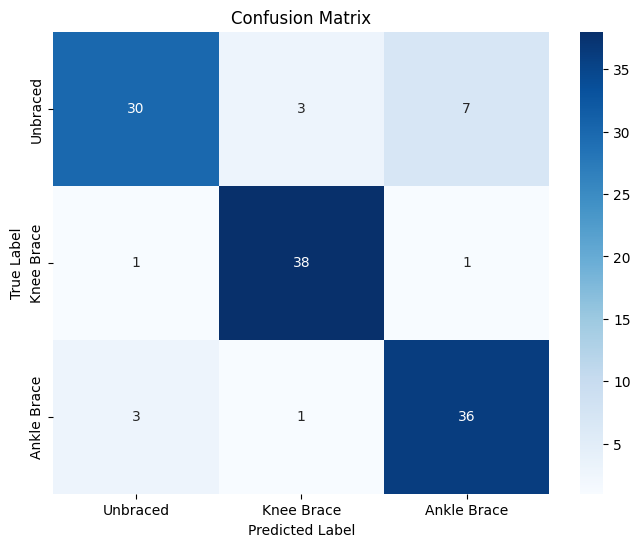

In [11]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Get model predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_one_hot, axis=1)

# Classification Report
print("\nClassification Report:")
class_names = ['Unbraced', 'Knee Brace', 'Ankle Brace']
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Results:
The LSTM model performed exceptionally well, achieving ~99% accuracy on the unseen test data. The classification report confirms this with high precision, recall, and F1-scores across all three classes. The confusion matrix shows only one or two misclassifications, demonstrating the model's robustness.

Key Insights:

The distinct changes in joint angle patterns caused by knee and ankle braces provide strong signals that a machine learning model can easily learn.

Reshaping the data from a long format into sequences of (samples, timesteps, features) was the critical preprocessing step for leveraging the power of LSTMs.

Even a relatively simple LSTM architecture can achieve high performance on this type of biomechanical time-series data.

